# Using Machine Learning to Forecast Electricity Usage in the future

## The past dictates the future - or does it?
Forecasting time series data is different to other forms of machine learning problems due a one main reason - time series data often is correlated with the past. That is, today's value is influenced by, for example, yesterday's value, last week's value etc. This is known as 'autocorrelation' (ie correlating with 'self').

Because time series has autocorrelation, many traditional machine learning algorithm that consider every data point 'independent' don't work well. That is, every prediction is solely based on a particular day's data, and not what happened yesterday, day before etc.

To put it bluntly, traditional machine learning algorithms have **no concept of the passage of time - every single data point is just a 'row in the table'.** It doesn't factor into trends, which as humans, we would intuitively see (e.g. sales went up by 20% this week).

Generally, to make a machine learning model factor data from a particular point's past, you use 'shifting' feature engineering techniques. That is, for example, expressly adding in yesterday's value show as a feature/column for the model to consider.

This illustration will attempt to forecast energy consumption to give a bit of flavour of how time series forecasting works, comparing:

1. Holtwinters Triple Exponential Smoothing
2. Seasonal Autoregression Integrated Moving Average (SARIMA)
3. XGBoost Regressor
4. Facebook’s Prophet

## A showcase of time series forecasting - electricity usage!
In the electricity industry, being able to forecast the electricity usage in the future is essential and a core part of any electricity retailer's business. The electricity usage of an electricity retailer's customers is generally known as the retailer's 'load' and the usage curve is known as the 'load curve'.

Being able to accurately forecast load is important for a number of reasons:

**Predict the future base load** - electricity retailers need to be able to estimate how much electricity they need to buy off the grid in advance.
**Smooth out pricing** - if the load is known is advance, electricity retailers can hedge against the price to ensure they aren't caught out when the price skyrockets 3 months into the future.

In a nutshell, the business problem is:

**Given the historical power consumption, what is the expected power consumption for the next 365 days?**

Because we want to predict the daily load for the next 365 days, there are multiple 'time steps' and this form of forecasting is known as 'multi-step forecasting'. In contrast, if you only wanted to predict the load on the 365th day or the load for tomorrow only, this would be known as a 'one-step forecast'.

This dataset is from https://www.kaggle.com/robikscube/hourly-energy-consumption:

> PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.
> 
> The hourly power consumption data comes from PJM's website and are in megawatts (MW).
> 
> The regions have changed over the years so data may only appear for certain dates per region.

# Housekeeping and Preprocessing

In [1]:
import pandas as pd
from datetime import datetime

# Configure matplotlib plotting
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.style.use('fivethirtyeight')

from pylab import rcParams
rcParams['figure.figsize'] = 11, 9 #Changes default matplotlib plots to this size

# Exploratory Data Analysis

We need to first check a few things:
1. Duplicate and missing data, as well as spread
2. How autocorrelated is this data and its seasonal decomposition

In [2]:
# Load my EDA helper function created to do some high-level analysis
class EDA():

    df = pd.DataFrame()
    
    def __init__(self, df):
        '''
        Creates EDA object for the DataFrame
        
        Note for time series data, have the index be the timestamp prior to creating this Object.
        
        :param df : DataFrame
        '''
        self.df = df
        
    def missing_values(self):
        '''
        Checks missing values
        
        :return DataFrame
        
        '''
        missing = self.df[self.df.isna().any(axis=1)]
        
        print("Missing values data")
        
        return missing
    
    def duplicate_values(self):
        duplicates = self.df[self.df.duplicated(subset=None, keep='first')==True]
        
        print("Duplicate values data")
        
        return duplicates
        
    def duplicate_indices(self):
        '''
        Check whether the indices have any duplicates
        
        :return DataFrame
        '''        
        duplicate_indices = self.df[self.df.index.duplicated()==True]
        
        print("Duplicate indices")
        
        return duplicate_indices
            
    def summary(self):
        '''
        Return summary/describe of DataFrame
        
        :return DataFrame
        '''
        df = self.df.reset_index() # Reset to include the index
        
        summary = df.describe(include='all').transpose()
        
        print("Summary metrics")
        
        return summary
    
    def pandas_profiling(self):
        import pandas_profiling
        
        self.df.profile_report(style={'full_width':True})  
    
    def histogram_KDE(self):
        ''' 
        :return seaborn plot
        '''       
        sns.pairplot(self.df, diag='kde')
        sns.distplot(kde=True, fit=[st.norm or st.lognorm])
        
    def outliers(self, col):
        ''' 
        Checks outliers - anything outside of 5% to 95% quartile range
        
        :param col : str
            Name of col to be tested
            
        :return DataFrame
        '''
        outliers = self.df[~self.df[col].between(self.df[col].quantile(.05), self.df[col].quantile(.95))]
        
        print("Outliers")
        
        return outliers
        
    def missing_timeseries_points(self, freq='D'):
        '''
        Checks whether there's any missing data points in continuous time series data.
        
        :param freq optional default = 'D' : str
            Frequency compliant with pandas formatting
        
        :return DataFrame
        '''
        # First create date range
        date_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq=freq)

        # Now compare against dataset
        missing_timeseries = self.df.index[~self.df.index.isin(date_range)]
        
        print("Missing timeseries data")
        
        return missing_timeseries

    def corr_heatmap(df):
        fig, ax = plt.subplots(figsize=(10, 6))
        corr = self.df.corr()
        hm = sns.heatmap(round(corr,2), annot=True, cmap="coolwarm",fmt='.2f', linewidths=.05)
        fig.subplots_adjust(top=0.93)
        title = fig.suptitle('Wine Attributes Correlation Heatmap', fontsize=14)

        plt.show()

    def plot_time_series_seasonal_decomp(self, type='add'):
        '''
        Plots seasonal decomposition of timeseries data
        
        :return matplotlib Plot
        '''
        from statsmodels.tsa.seasonal import seasonal_decompose
        decomposition = seasonal_decompose(self.df, model='multiplicative')

        fig = decomposition.plot()
        plt.show()
   
    def time_series_ADF(self):            
        '''
        Returns Augmented Dickey-Fuller Test
        '''
        from statsmodels.tsa.stattools import adfuller as ADF

        series = data['KwH'] # ADF takes series, not DF

        result = ADF(series)

        print('ADF Statistic: %f4.2' % result[0])
        print('P-value %f4.2' % result[1])

First let's have a look at the dataset - first few lines:

In [3]:
# Load the Data
data = pd.read_csv("../input/hourly-energy-consumption/PJME_hourly.csv")

data.set_index('Datetime',inplace=True)

data.index = pd.to_datetime(data.index)

data_copy = data.copy(deep=True) # Make a deep copy, including a copy of the data and the indices
data.head(10)

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
2002-12-31 06:00:00,26222.0
2002-12-31 07:00:00,28702.0
2002-12-31 08:00:00,30698.0
2002-12-31 09:00:00,31800.0


Next let's have a look at some of the summary EDA data, missing values and duplicates:

In [4]:
eda_helper = EDA(data)

eda_helper.summary()

Summary metrics


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Datetime,145366,145362,2014-11-02 02:00:00,2,2002-01-01 01:00:00,2018-08-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PJME_MW,145366,NaN,NaT,NaN,NaT,NaT,32080.2,6464.01,14544,27573,31421,35650,62009


In [5]:
eda_helper.missing_values()

Missing values data


,PJME_MW
Datetime,


In [6]:
eda_helper.duplicate_values()

Duplicate values data


,PJME_MW
Datetime,
2002-12-28 03:00:00,27526.0
2002-12-25 23:00:00,30698.0
2002-12-23 12:00:00,33144.0
2002-12-22 03:00:00,24907.0
2002-12-20 05:00:00,24363.0
...,...
2018-01-01 18:00:00,44147.0
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0


In [7]:
eda_helper.duplicate_indices()

Duplicate indices


,PJME_MW
Datetime,
2014-11-02 02:00:00,23755.0
2015-11-01 02:00:00,21171.0
2016-11-06 02:00:00,21692.0
2017-11-05 02:00:00,20666.0


Next we'll process it so the data is at the hourly level:

In [8]:
def preprocess_data(df):
    # We have duplicates, so we need to de-duplicate it - grabbing first value that pops up for a time series
    df.sort_index()
    df = df.groupby(df.index).first()
    
    #Set freq to H
    df = df.asfreq('H')
    
    return df

In [9]:
data = preprocess_data(data)

data.index

DatetimeIndex(['2002-01-01 01:00:00', '2002-01-01 02:00:00',
               '2002-01-01 03:00:00', '2002-01-01 04:00:00',
               '2002-01-01 05:00:00', '2002-01-01 06:00:00',
               '2002-01-01 07:00:00', '2002-01-01 08:00:00',
               '2002-01-01 09:00:00', '2002-01-01 10:00:00',
               ...
               '2018-08-02 15:00:00', '2018-08-02 16:00:00',
               '2018-08-02 17:00:00', '2018-08-02 18:00:00',
               '2018-08-02 19:00:00', '2018-08-02 20:00:00',
               '2018-08-02 21:00:00', '2018-08-02 22:00:00',
               '2018-08-02 23:00:00', '2018-08-03 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145392, freq='H')

After preprocessing and cleaning up the data, as well as making sure the frequency is at the hourly level, let's plot the data.

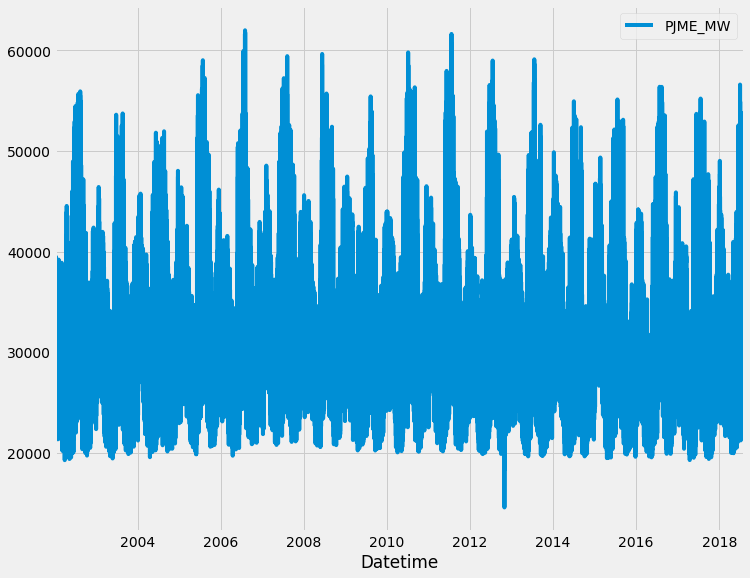

In [10]:
# Let's visualise the data
data.plot()

plt.show()

You can see because the frequency is at the hourly level, this is will make forecasting difficult (and its also difficult to visualise too!)

So what we will do is resample it and aggregate it to the daily level

In [11]:
# Given there's no missing data, we can resample the data to daily level
daily_data = data.resample(rule='D').sum()

# Set frequency explicitly to D
daily_data = daily_data.asfreq('D')

daily_data.head(10)

,PJME_MW
Datetime,
2002-01-01,714857.0
2002-01-02,822277.0
2002-01-03,828285.0
2002-01-04,809171.0
2002-01-05,729723.0
2002-01-06,727766.0
2002-01-07,800012.0
2002-01-08,824710.0
2002-01-09,810628.0


In [12]:
# We can confirm it is at the right frequency
daily_data.index

DatetimeIndex(['2002-01-01', '2002-01-02', '2002-01-03', '2002-01-04',
               '2002-01-05', '2002-01-06', '2002-01-07', '2002-01-08',
               '2002-01-09', '2002-01-10',
               ...
               '2018-07-25', '2018-07-26', '2018-07-27', '2018-07-28',
               '2018-07-29', '2018-07-30', '2018-07-31', '2018-08-01',
               '2018-08-02', '2018-08-03'],
              dtype='datetime64[ns]', name='Datetime', length=6059, freq='D')

Let's visualise the data again

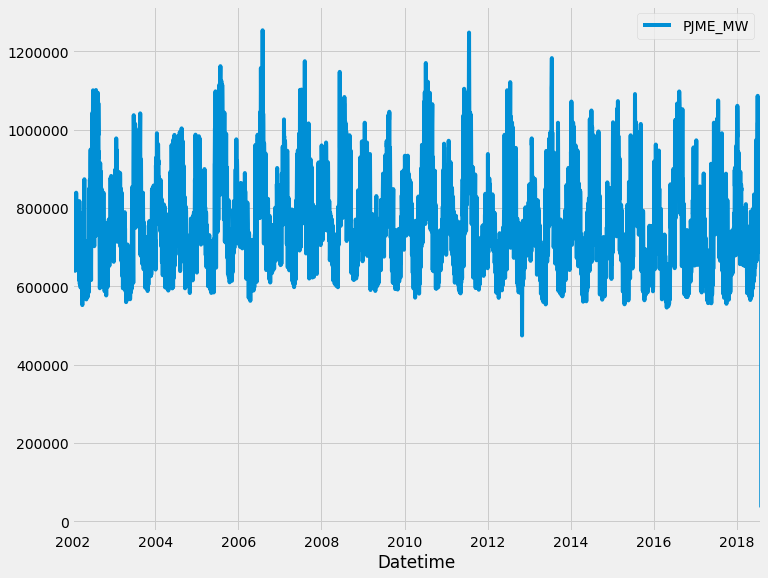

In [13]:
daily_data.plot()

plt.show()

Now there's a tail end where it's not a full day, so it's dropping off.

For our purposes, we will just delete that part day.

In [14]:
daily_data = daily_data.drop([daily_data.index.min(), daily_data.index.max()])

Good, so there's no missing or duplicate data and you can see the data is from 1 Jan 2002 to 2 August 2018.

**Seasonal Decomposition**

At a high-level, time series data can be thought of as components put together. That is:

**Data = Level + Trend + Seasonality + Noise**

* **Level**: the average value in the series.
* **Trend**: the increasing or decreasing value in the series.
* **Seasonality**: the repeating short-term cycle in the series.
* **Noise/Residual**: the random variation in the series.

Using the Python statsmodel library, the above components can be 'decomposed' (ie seasonal decomposition):

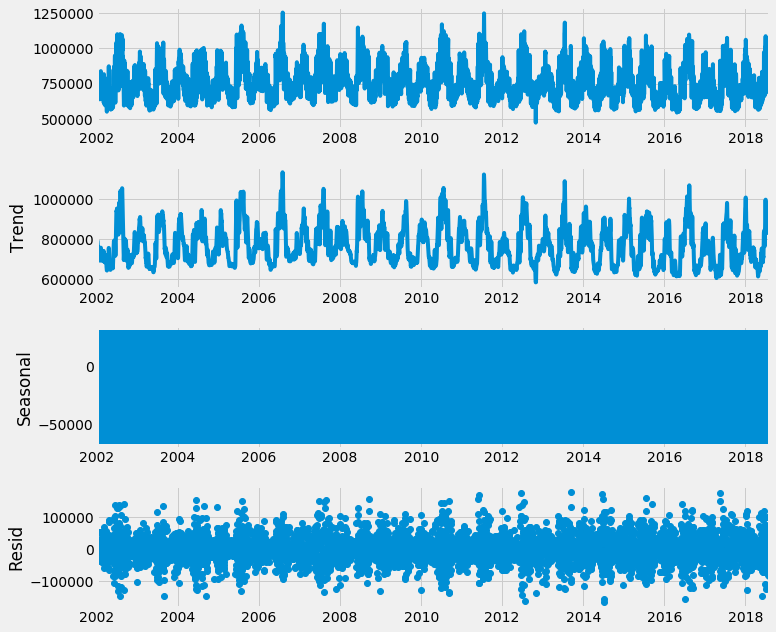

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(daily_data, model='additive')

fig = decomposition.plot()
plt.show()

One thing that jumps out right now is very difficult to see what's going on, as the graph is very 'packed together'.

More 'traditional' econometric/statistical models, such as Holtwinters and SARIMA, require 3 characteristics for them to work properly, namely:

* Seasonality: the dataset is cyclical in nature
* Stationarity: the properties of the dataset doesn't change over time
* Autocorrelation: there is similiar between current and past (ie 'lagged') data points

How about we aggregate up to weekly level to reduce the noise

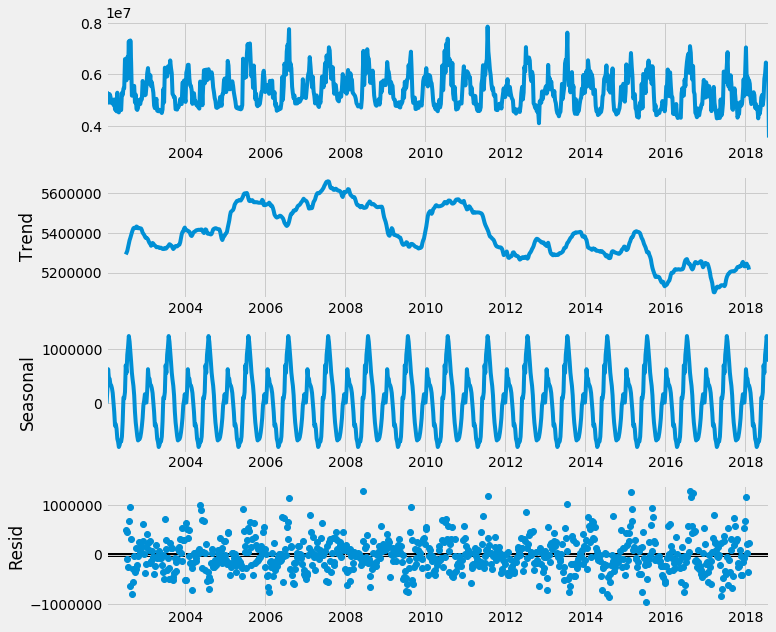

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
weekly_data = data.resample(rule='W').sum()
decomposition = seasonal_decompose(weekly_data, model='additive') # Aggregate to weekly level

fig = decomposition.plot()
plt.show()

You can see start to see a pattern - electricity usage peak and troughs seem to be very seasonal and repetitive. This makes sense, considering office hours, weather patterns, shopping holidays etc.

Furthermore, you can see the trend of the data seems to be trailing downwards in the last few years.

Another way to visualise seasonality is to use a heatmap - we can base it on a week to see which days have higher electricity usage.

Note we will drop off 2018 because it's not a full year and will skewer the heatmap.

First let's construct the dataframe table.

In [17]:
# Create new dataset for heatmap
heatmap_data = daily_data.copy()

# First we need to add weekdays as a column
heatmap_data['Weekday_Name'] = daily_data.index.weekday_name

# Next we add the year as column and group the data up to annual day of week level
heatmap_data['Year'] =  heatmap_data.index.year
heatmap_data = heatmap_data.groupby(['Year', 'Weekday_Name']).sum()

# Reset index 
heatmap_data = heatmap_data.reset_index()

# We drop off 2018 because it's not a full year
heatmap_data = heatmap_data[heatmap_data['Year'] != 2018]

# Pivot it to a uniform data format for heatmaps
heatmap_data = heatmap_data.pivot(index='Year', columns='Weekday_Name', values='PJME_MW')

# Reorder columns
heatmap_data = heatmap_data[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

heatmap_data.head(100)

Weekday_Name,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Year,,,,,,,
2002,40559596.0,41562544.0,41502149.0,40797927.0,39906312.0,36214879.0,35161845.0
2003,40418610.0,40978444.0,41535338.0,40835617.0,40674536.0,37247732.0,35927451.0
2004,41011526.0,42102790.0,42042876.0,42615827.0,42037861.0,37627342.0,35960737.0
2005,42042356.0,43071343.0,43424862.0,43016356.0,42521582.0,39916126.0,37740547.0
2006,41391013.0,42255918.0,42123538.0,41725185.0,40968212.0,37624531.0,37751987.0
2007,43320074.0,43249803.0,43469850.0,43457948.0,43282207.0,39448117.0,38158759.0
2008,42365670.0,43269506.0,42724055.0,42075739.0,41657663.0,38847059.0,38247997.0
2009,40587543.0,41308337.0,41264638.0,41615581.0,40439728.0,37414190.0,36325715.0
2010,42014183.0,42746828.0,42806347.0,42812321.0,42390205.0,38800302.0,38296783.0


Then we visualise it:

Text(0.5, 1.0, 'Heatmap - by Day of Week')

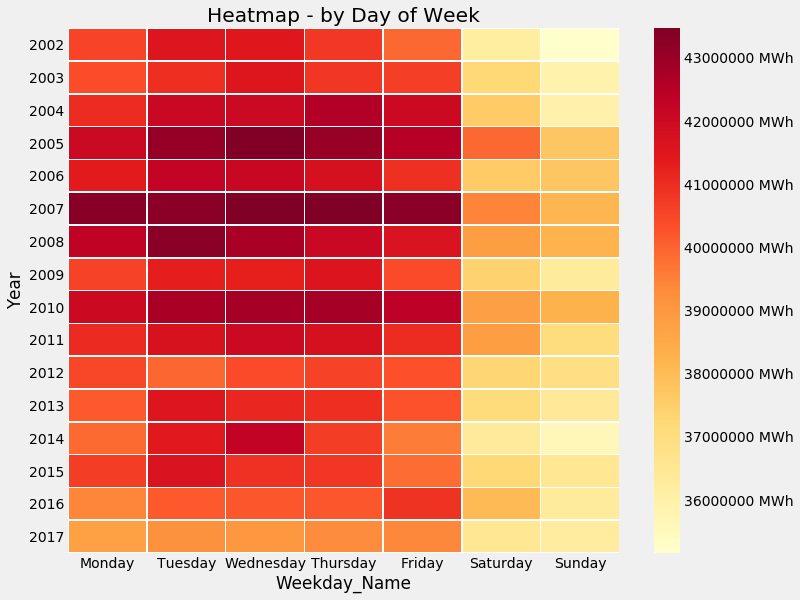

In [18]:
# Visualise electricity load via Heatmap
sns.heatmap(heatmap_data, linewidths=.5, cmap='YlOrRd', cbar=True, cbar_kws={"format": '%1.0f MWh'}).set_title('Heatmap - by Day of Week')

So using this you can see (as expected) the weekend has lower electricity use. Many businesses are closed during weekends and therefore this makes sense.

Now let's do the same thing but over the hours of a day (to sort of see peak operating hours)

In [19]:
# Create new dataset for heatmap
heatmap_data = data.copy()

# First we need to add weekdays as a column
heatmap_data['Hour'] = data.index.hour

# Next we add the year as column and group the data up to annual day of week level
heatmap_data['Year'] =  heatmap_data.index.year
heatmap_data = heatmap_data.groupby(['Year', 'Hour']).sum()

# Reset index 
heatmap_data = heatmap_data.reset_index()

# We drop off 2018 because it's not a full year
heatmap_data = heatmap_data[heatmap_data['Year'] != 2018]

# Pivot it to a uniform data format for heatmaps
heatmap_data = heatmap_data.pivot(index='Year', columns='Hour', values='PJME_MW')

heatmap_data.head(100)

Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Year,,,,,,,,,,,,,,,,,,,,,
2002,10555395.0,9815263.0,9335986.0,9085390.0,8996000.0,9088508.0,9561362.0,10478310.0,11256367.0,11754869.0,...,12659081.0,12635909.0,12644627.0,12801822.0,13099769.0,13118837.0,12973435.0,12845175.0,12421482.0,11546851.0
2003,10628849.0,9876055.0,9416911.0,9185955.0,9114624.0,9218899.0,9731298.0,10665568.0,11425318.0,11897609.0,...,12626754.0,12584423.0,12570529.0,12722624.0,13024083.0,13067172.0,12972139.0,12872530.0,12455050.0,11588825.0
2004,10853980.0,10082380.0,9611380.0,9361850.0,9284763.0,9393423.0,9913531.0,10850183.0,11608294.0,12079820.0,...,12904112.0,12878572.0,12890501.0,13059614.0,13364466.0,13403130.0,13284203.0,13169499.0,12732275.0,11830098.0
2005,11165424.0,10392273.0,9908003.0,9655564.0,9575405.0,9685438.0,10208623.0,11136212.0,11878090.0,12359541.0,...,13304389.0,13296409.0,13322850.0,13499920.0,13806159.0,13817318.0,13684655.0,13568005.0,13099973.0,12165342.0
2006,10853993.0,10093946.0,9614511.0,9366089.0,9283392.0,9400221.0,9935520.0,10868819.0,11600873.0,12055666.0,...,12938660.0,12918631.0,12928152.0,13094555.0,13411002.0,13450723.0,13348270.0,13233525.0,12762157.0,11835063.0
2007,11262044.0,10494234.0,10007425.0,9749737.0,9664983.0,9779899.0,10314407.0,11255053.0,11973216.0,12426800.0,...,13442092.0,13452764.0,13489220.0,13670753.0,13949904.0,13920435.0,13806061.0,13687188.0,13200416.0,12263570.0
2008,11059884.0,10308613.0,9838353.0,9583564.0,9509533.0,9631277.0,10165640.0,11097072.0,11814795.0,12270475.0,...,13182511.0,13173988.0,13199151.0,13379730.0,13665619.0,13632975.0,13529163.0,13419051.0,12934264.0,12021209.0
2009,10677082.0,9950818.0,9497676.0,9259915.0,9191123.0,9315637.0,9841604.0,10763158.0,11458723.0,11894708.0,...,12685003.0,12651859.0,12656051.0,12826320.0,13130439.0,13119984.0,13028323.0,12930061.0,12463858.0,11589842.0
2010,11082724.0,10361409.0,9874260.0,9612052.0,9524115.0,9637261.0,10148449.0,11047130.0,11745956.0,12204406.0,...,13245648.0,13254547.0,13292825.0,13479719.0,13777104.0,13749396.0,13607821.0,13461319.0,12961111.0,12060879.0


Text(0.5, 1.0, 'Heatmap - by Hour of Day')

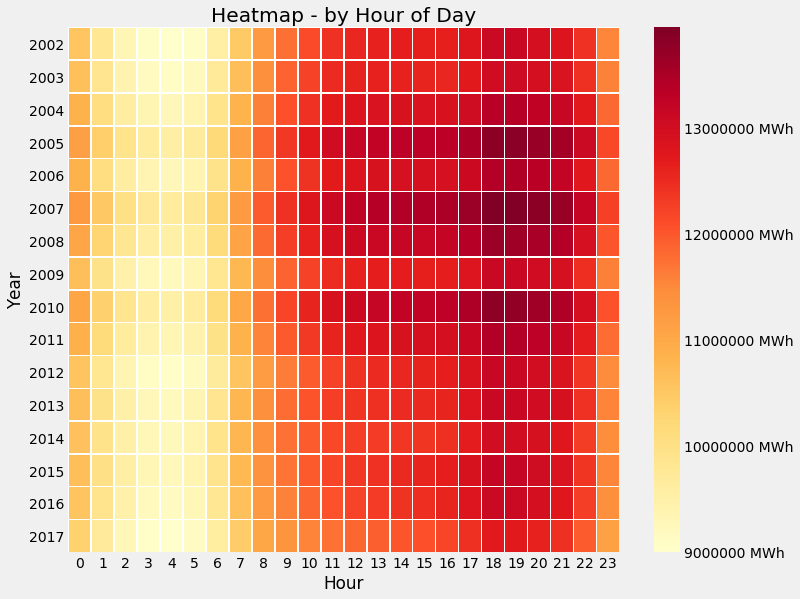

In [20]:
# Visualise electricity load via Heatmap
sns.heatmap(heatmap_data, linewidths=.5, cmap='YlOrRd', cbar=True, cbar_kws={"format": '%1.0f MWh'}).set_title('Heatmap - by Hour of Day')

Interestingly, it means 11am to 9pm is the busiest peak time of the grid.

We can also do the same with a 'season plot' - that is, compare each year over 12 months:

In [21]:
# Create new dataset for heatmap
heatmap_data = daily_data.copy()

# First we need to add weekdays as a column
heatmap_data['Month'] = daily_data.index.month_name()

# Next we add the year as column and group the data up to annual day of week level
heatmap_data['Year'] =  heatmap_data.index.year
heatmap_data = heatmap_data.groupby(['Year', 'Month']).sum()

# Reset index
heatmap_data = heatmap_data.reset_index()

# We drop off 2018 because it's not a full year
heatmap_data = heatmap_data[heatmap_data['Year'] != 2018]

# Pivot it to a uniform data format for heatmaps
heatmap_data = heatmap_data.pivot(index='Year', columns='Month', values='PJME_MW')

# Reorder columns
heatmap_data = heatmap_data[['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']]

heatmap_data.head(10)

Month,January,February,March,April,May,June,July,August,September,October,November,December
Year,,,,,,,,,,,,
2002,22374165.0,20320720.0,21483191.0,20516472.0,20886798.0,24181862.0,28303171.0,28282432.0,22522657.0,21425753.0,21181133.0,24226898.0
2003,26029003.0,22876353.0,22463917.0,20361487.0,20229013.0,22763740.0,27096616.0,27666731.0,22010477.0,20871168.0,20817246.0,24431977.0
2004,26849900.0,23182028.0,22525939.0,20607391.0,23401869.0,23978879.0,26753607.0,26545361.0,22883683.0,20931584.0,21127232.0,24611486.0
2005,25835806.0,22366527.0,23811599.0,20238773.0,20595988.0,26046220.0,29282426.0,29802886.0,24685915.0,21794083.0,21558593.0,25714356.0
2006,24270315.0,22521844.0,23141132.0,19923539.0,21583435.0,24783648.0,29831183.0,28960439.0,21789803.0,21748478.0,21532040.0,23754528.0
2007,24983987.0,24755455.0,23665732.0,21410696.0,22584831.0,25418693.0,27831684.0,28767385.0,24212850.0,23110059.0,22312039.0,25333347.0
2008,25751328.0,23942544.0,23198205.0,20859037.0,21297058.0,26421539.0,29230849.0,26096686.0,23493887.0,21650056.0,22154691.0,25091809.0
2009,27044859.0,22456331.0,22876393.0,20700711.0,21136769.0,22849599.0,25671848.0,27921912.0,21395741.0,21024346.0,20680583.0,25196640.0
2010,26032810.0,23282363.0,22128750.0,19882493.0,22336022.0,26768482.0,30201895.0,27899413.0,23380316.0,20633375.0,21104892.0,26216158.0


Text(0.5, 1.0, 'Heatmap - by Day of Week')

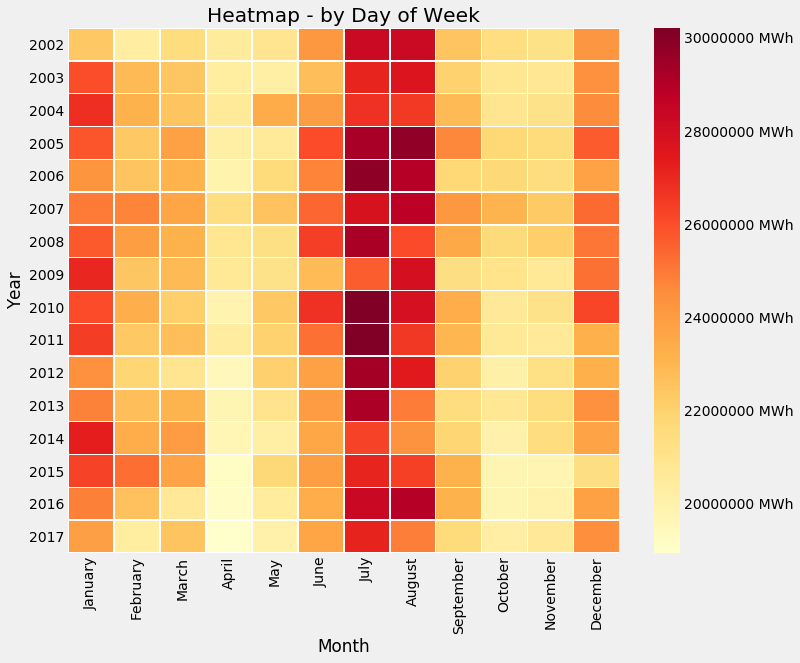

In [22]:
# Visualise electricity load via Heatmap
sns.heatmap(heatmap_data, linewidths=.5, cmap='YlOrRd', cbar=True, cbar_kws={"format": '%1.0f MWh'}).set_title('Heatmap - by Day of Week')

So you can see that July has the heaviest load on the grid - which makes sense as it is the height of summer in the region.

Air conditioners are expensive after all!

# Statistical Test 'Smoke Alarms'

Statistical Tests are a good way to test whether the data is conductive to conventional statistical methods.

There are certain good statistical tests you can apply to a dataset as a 'smoke alarm' test. They are a good indication whether the data is conducive to accurate forecasting.

Both the below statistical tests use Hypothesis Testing and P-Values, which require a cutoff to be picked in advance. The general rule of thumb is 5% - which means there's a only a 5% chance of the statistical tests to be incorrect.

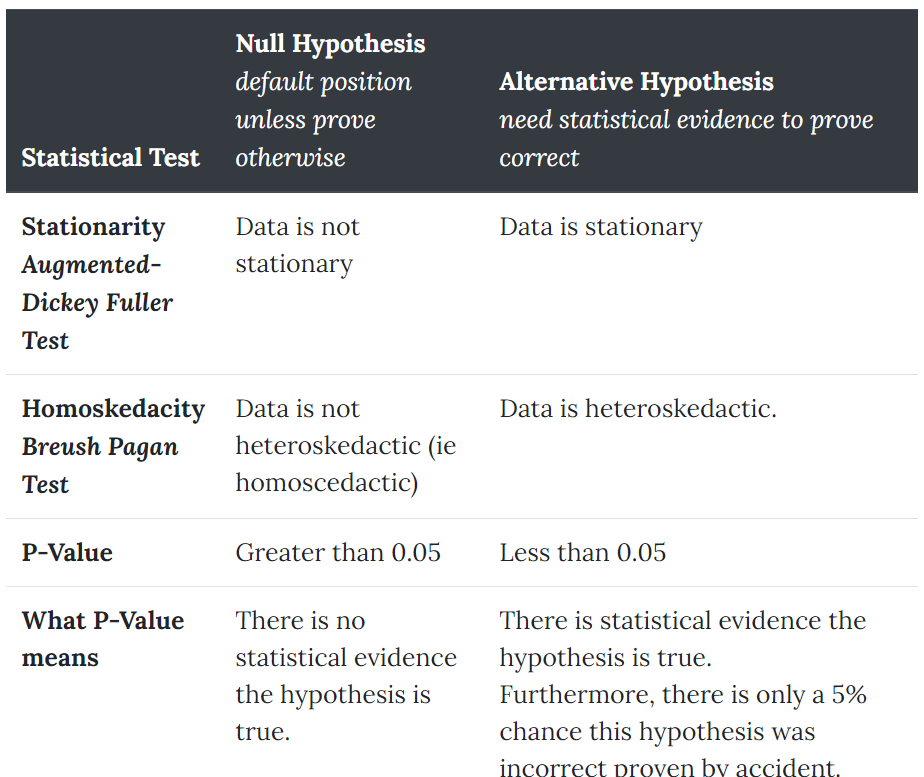


'**Stationary**' means the properties of the dataset don't change over time. Non-stationary means the trends, seasonality changes over time and the data is affected by factors other than the passsage of time. A Non-Stationary is sometimes known as a 'Random Walk' - which are notoriously difficult to forecast, because the underlying properties keep changing (e.g. like trying to hit a moving target).

Note that Random Walk is different to a set of 'random numbers' - it's random because the next point is based on a 'random' modification on the first point (e.g. add, minus, multiply). Whereas in a 'random numbers' set, ther would be little relationship between each data point.

So let's run the test for Stationarity and see the results: 

In [23]:
from statsmodels.tsa.stattools import adfuller as ADF

series = daily_data['PJME_MW'] # ADF takes series, not DF

result = ADF(series)

print('ADF Statistic: ', result[0])
print('P-value: {:.20f}'.format(result[1]))

ADF Statistic:  -8.236535732363487
P-value: 0.00000000000058695232


'**Heteroskedacity**' refers to instances where the data is evenly distributed along a regression line. Basically it means the data is more closely grouped together and therefore is less 'spiky' (ie has more peaks/troughs).

Heteroskedactic data means the peaks and troughs (ie outliers) are being observed way more often than a 'normally distributed' dataset. This means that a model will have a hard time predicting these spikes.

To alleviate this, heteroskedactic data generally needs to be Box-Cox/log transformed to dampen the extreme peaks/troughs. That is, bringing the data closer together so a model can better fit the whole data and hit the peaks/troughs.

So let's run the test for Heteroskedacity and see the results: 

In [24]:
from statsmodels.stats.diagnostic import het_breuschpagan as BP
import statsmodels.api as sm
from statsmodels.formula.api import ols

bp_data = daily_data.copy()
bp_data['Time_Period'] = range(1, len(bp_data)+1) # Convert time series points into consecutive ints

formula = 'PJME_MW ~ Time_Period' # ie PJME MW depends on Time Period (OLS auto adds Y intercept)

# Next we apply Ordinary Linear Square baseline regression model - as baseline test
model = ols(formula, bp_data).fit()

result = BP(model.resid, model.model.exog)

print('ADF Statistic: ', result[0])
print('P-value: {:.20f}'.format(result[1]))

ADF Statistic:  1.3342565233934085
P-value: 0.24804938724348729595


In our case, we got the following results:
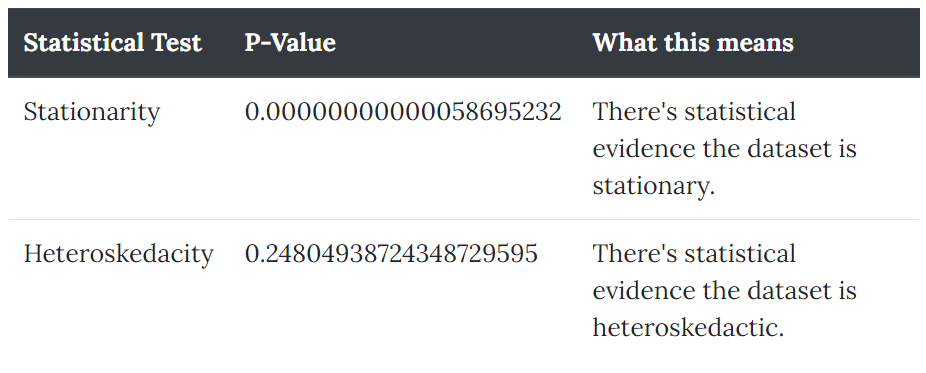

You can see both the seasonal decomposition and ADF show this data has a lot of noise and crazy swings!!

The consequences of these statistical tests means that the traditional assumptions of linear regression have been violated. That is, more conventional methods of linear regression, statistical F-Tests and T-Tests become ineffective.

Therefore, this forecasting model won't factor in these tests.

# Autocorrelation
Autocorrelation is basically how much correlation there is between a particular time point and a prior one - e.g. today's value is highly correleated with last week's value.

Again, Python Statsmodel has a great Autocorrelation Function (ACF) that easily produces this:

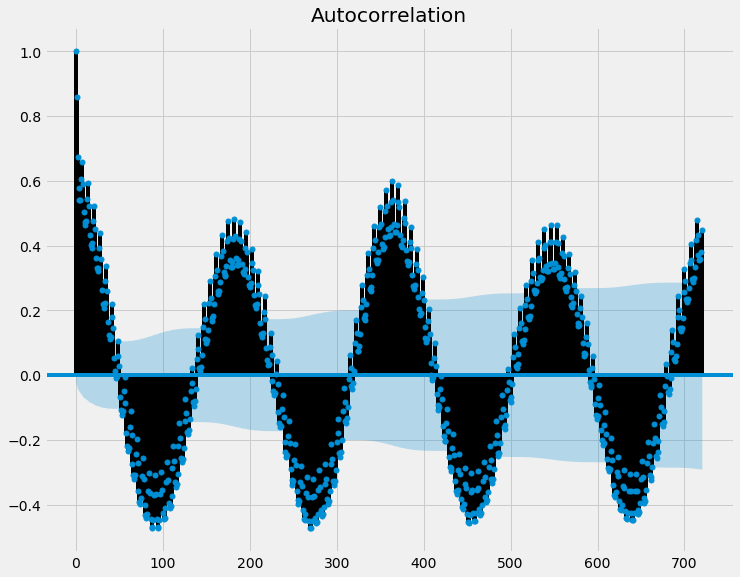

In [25]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

#fig, ax = plt.subplots(2,1)

# Plot the acf function
plot_acf(daily_data['PJME_MW'],lags=720) #alpha 1 suppresses CI

plt.show()

What the above graph shows is how correlated a prior point is to the current point. The further the number is away from 0, the more correlation there is.

Generally, we would only consider any points above (for positive numbers) and below (for negative numbers) the blue shaded area (the confidence interval) as statistically significant and worth noting.

This shows that yesterday's value has a very high correlation with today's value and there is seasonality - every 6 months it seems to repeat itself.

As eluded earlier, this makes sense if you factor in weather patterns - winter and summer have higher electricity usage due to more heat/cooling needed.

My personal guess is because of weather - winter and summer have higher electricity usage.

Another modification of this autocorrelation analysis is the Partial Autocorrelation Function (PACF). This function is a variant of ACF, as it finds correlation of the residuals, after removing the effects which are already explained in earlier lags. That way, you don't get a 'compounding' correlation effect.

This graph shows that the last 90 days have a stronger correlation, but the effect becomes much less obvious the further back you go.

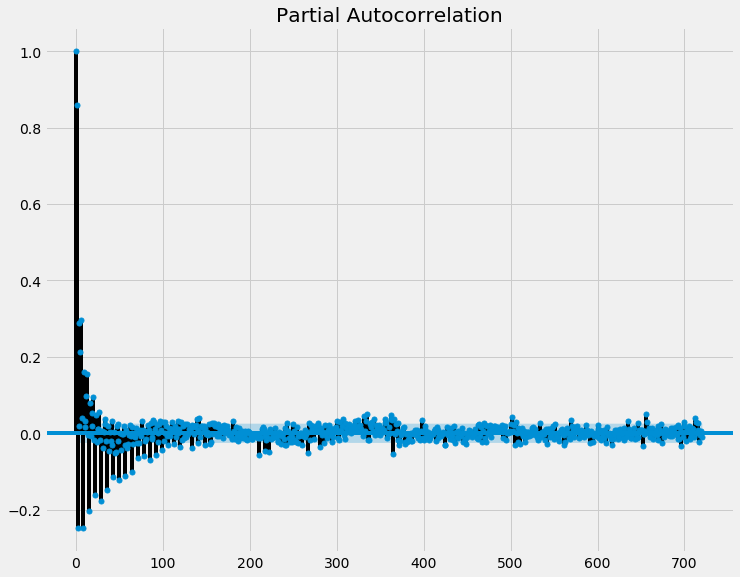

In [26]:
plot_pacf(daily_data['PJME_MW'],lags=720) #alpha 1 suppress CI

plt.show()

# Train Test Split 
Before we continue, let us split the data up between train and split with a specified cutoff date.

Let's pick 3 August 2017 (12 months prior)

In [27]:
# First we split it up between train and test
# We will aim for a 12 month forecast horizon (ie predict the last 12 months in the dataset)
cutoff = '2017-08-03'

daily_data.sort_index()

train = daily_data[:cutoff]
test = daily_data[cutoff:]

# Baseline Model - Naive Forecasting

Before we go knee-deep into machine learning, it is good to use naive forecasting techniques to determine a 'baseline'. That is, if the ML models cannot beat these baseline forecasts, then we would be better off just using naive forecast instead.

They are 'naive' in the sense they are simple to apply, but in reality they are pretty powerful and effective forecasts. Not too many ML models actually can consistently beat a naive forecast!

A common naive forecast for predicting a multi-step forecast (i.e. for us, it would be the next 365 days), is to use a 'One-Year-Ago Persistent Forecast'. This basically means the value for say 31 August 2019 is predicted using the value for 31 August 2018.

In [28]:
baseline_prediction = train['2016-08-03':'2017-08-02']

baseline_prediction.index = pd.date_range(start='2017-08-03', end='2018-08-02', freq='D')

baseline_prediction.tail()

,PJME_MW
2018-07-29,700426.0
2018-07-30,672616.0
2018-07-31,830714.0
2018-08-01,914385.0
2018-08-02,895428.0


Let's evaluate our model using Mean Absolute Error (MAE) and visualise the results.

Mean Absolute Error (MAE) is an evaluation metric that measures the average magnitude of the errors in a set of predictions. In other words how 'wrong' the model is. Unlike other metrics, such as Root Mean Squared Error, it does not have any particular weighting.

Training data is in blue, while test/evaluation data is in red.

In [29]:
# Evaluate it's performance using Mean Absolute Error (MAE)
from statsmodels.tools.eval_measures import meanabs

print("MAE Baseline: {:.20f}".format(meanabs(test['PJME_MW'], baseline_prediction['PJME_MW'])))

MAE Baseline: 87418.90958904109720606357


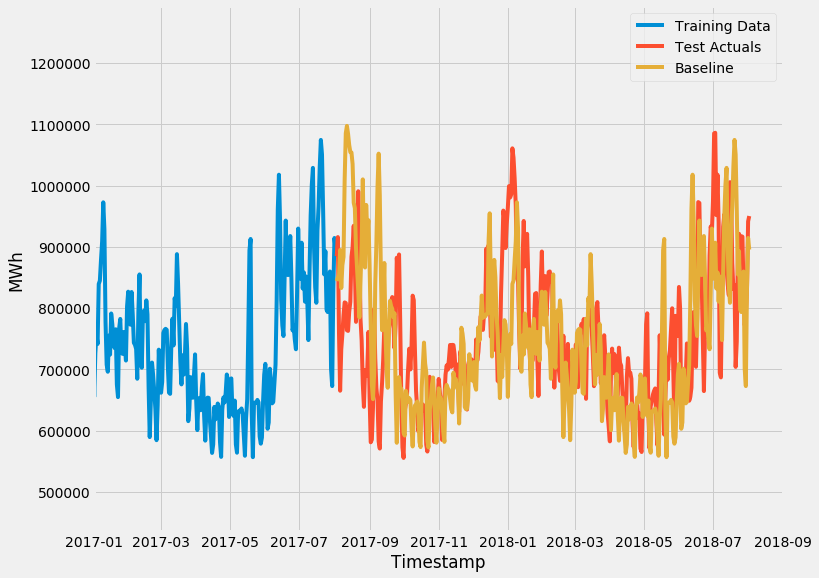

In [30]:
# Let's visually see the results
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Actuals')
plt.plot(baseline_prediction, label='Baseline')

# Plot Labels, Legends etc
plt.xlabel("Timestamp")
plt.ylabel("MWh")
plt.legend(loc='best')

# For clarify, let's limit to only 2017 onwards
plt.xlim(datetime(2017, 1, 1),datetime(2018, 9, 1))

plt.show()

Immediately you can see that it is pretty half-decent forecast!

# 1. Holtwinters Triple Exponential Smoothing
Next we will use a time series forecasting model that takes advantage of the above identified components.

This is known as a 'generative additive model', as the final forecast value is 'adding' together multiple components.

The 'Triple' refers to the three components:
1. **Level**
2. **Trend**
3. **Seasonality**

Holtwinters works really well when the data is seasonal and has trends.

'Smoothing' basically means more weight is put on more recent data compared to the past.

Note the main hyperparameters for the model are:
* **Additive vs Multiplicative **(ie 'add' or 'mul') 
* **Box Cox** - to use box cox log transformation to reduce the 'noise' of the data
* **Alpha** - smoothing factor between 0 and 1. 1 means will always take yesterday's value (naive forecasting). 0 means take simple average of past.

Additive means the formula looks more like this: Data = Level + Trend + Seasonality

Multiplicative means the formula looks more like this: Data = Level x Trend x Seasonality

We are using Box-Cox as heteroskedatic test before showed data requires dampening to reduce extremes.

In [31]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# First we split it up between train and test
htrain = train['PJME_MW'] # HWES takes series, not DF
htest = test['PJME_MW'] # HWES takes series, not DF

model = ExponentialSmoothing(
    htrain
    ,trend='add'
    ,seasonal='add'
    ,freq='D'
    ,seasonal_periods=90 #Default is auto estimated - 4 is quarterly and 7 is weekly
).fit(
    optimized=True # Default is True - auto estimates the other parameters using Grid Search
    ,use_basinhopping=True # Uses Basin Hopping Algorithm for optimising parameters
    ,use_boxcox='log' #Boxcox transformation via log
    #,smoothing_level= # Alpha
    #,smoothing_slope= # Beta
    #,smoothing_seasonal= # Gamma
)

HWES_prediction = model.predict(start=htest.index[0], end=htest.index[-1])

print("Finished training and predicting")

# Let's see what the model did
model.summary()

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


Finished training and predicting


Dep. Variable:,endog,No. Observations:,5693
Model:,ExponentialSmoothing,SSE,20159625523758.777
Optimized:,True,AIC,125364.035
Trend:,Additive,BIC,125988.852
Seasonal:,Additive,AICC,125367.363
Seasonal Periods:,90,Date:,"Thu, 04 Jun 2020"
Box-Cox:,True,Time:,07:10:15
Box-Cox Coeff.:,log,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_slope,1.3759e-09,beta,True


Using Holtwinters, data from 2002 to 2017 was used to train the model, while the remaining 2017 to 2018 data was used to test/evaluate the model's accuracy.

Training data is in blue, while test/evaluation data is in red.

Let's evaluate our model using Mean Absolute Error (MAE) and visualise the results

In [32]:
# Evaluate it's performance using Mean Absolute Error (MAE)
from statsmodels.tools.eval_measures import meanabs

print("MAE HWES ADD: {:.20f}".format(meanabs(htest, HWES_prediction)))

MAE HWES ADD: 158807.87162270283442921937


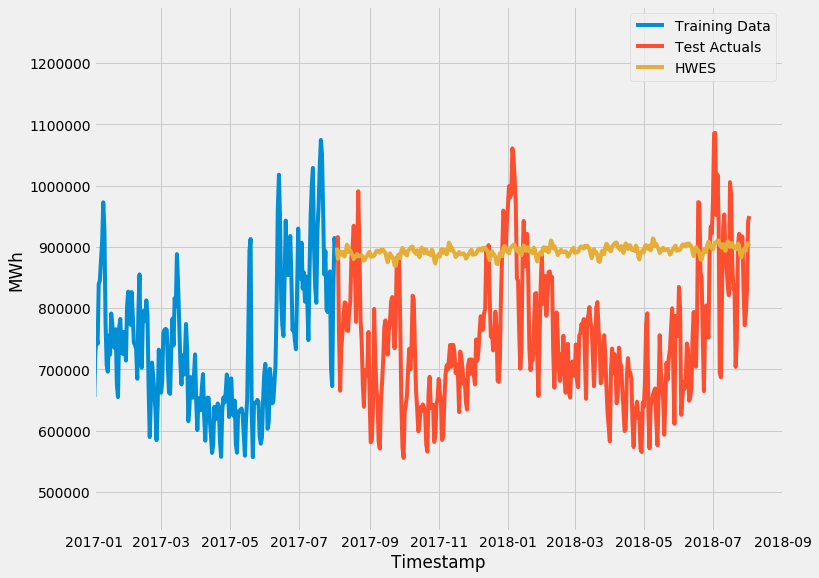

In [33]:
# Let's visually see the results
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Actuals')
plt.plot(HWES_prediction, label='HWES')

# Plot Labels, Legends etc
plt.xlabel("Timestamp")
plt.ylabel("MWh")
plt.legend(loc='best')

# For clarify, let's limit to only 2017 onwards
plt.xlim(datetime(2017, 1, 1),datetime(2018, 9, 1))

plt.show()

That's horrible! Let's try it again, but at the weekly level

In [34]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# First we split it up between train and test
weekly_train = train.resample(rule='W').sum()
weekly_test = test.resample(rule='W').sum()

# Remove partial days (first and last weeks)
weekly_train = weekly_train.drop([weekly_train.index.min(), weekly_train.index.max()])
weekly_test = weekly_test.drop([weekly_test.index.min(), weekly_test.index.max()])

# HWES takes series, not DF
htrain = weekly_train['PJME_MW']
htest = weekly_test['PJME_MW']

model = ExponentialSmoothing(
    htrain
    ,trend='add'
    ,seasonal='add'
).fit(
    use_boxcox='log'
)

HWES_prediction_weekly = model.predict(start=htest.index[0],end=htest.index[-1]) # Need to get the nearest start of week

print("Finished training and predicting")

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


Finished training and predicting


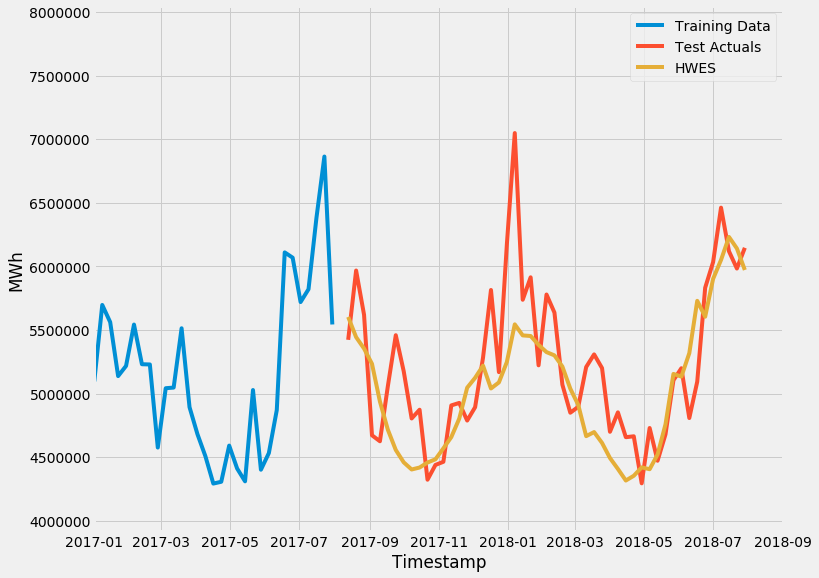

In [35]:
# Let's visually see the results
plt.plot(weekly_train, label='Training Data')
plt.plot(weekly_test, label='Test Actuals')
plt.plot(HWES_prediction_weekly, label='HWES')

# Plot Labels, Legends etc
plt.xlabel("Timestamp")
plt.ylabel("MWh")
plt.legend(loc='best')

# For clarify, let's limit to only 2017 onwards
plt.xlim(datetime(2017, 1, 1),datetime(2018, 9, 1))

plt.show()

In [36]:
# Evaluate it's performance using Mean Absolute Error (MAE)
from statsmodels.tools.eval_measures import meanabs

print("MAE HWES ADD Weekly: {:.20f}".format(meanabs(htest, HWES_prediction_weekly)))

MAE HWES ADD Weekly: 338986.40927244501654058695


It seems more accurate, but it is because its aggregated to weekly level.

So it seems Exponential Smoothing is a no-go - let's see how the others fare.

# XGBoost - Ensemble Learning

XGBoost has gained in popularity recently by being quite good at predicting many different types of problems.

Normally with decision-tree models, you would get the data and create one tree for it. This of course means it is very prone to overfitting and being confused by the unique tendencies of the past data.

To overcome this, you do 'gradient boosting'. At a very high-level, it is analogous to the algorithm creating a decision tree to try to predict the result, figure out how wrong it was, and then create another tree that learns from the first one's 'mistakes'.

This process is then repeated a few hundreds or even a few thousand times, with each tree being 'boosted' by the prior one's mistakes. The algorithm keeps going until it stops improving itself.

The technical aspects of the mathematics are much more complex (and a bit beyond my knowledge to bef honest). If you want more details, the documentation is here.

## Feature Engineering

As eluded earlier, most machine learning models don't 'look back' to prior values. Essentially if you have a table, each 'row' is an independent data point and the ML model doesn't consider the prior row's data.

This is problematic for time series data, as shown above, autocorrelation happens.

To address this issue, we use feature engineering to create additional features - in this case, I created 365 extra columns each prior day. Today minus 1 day, Today minus 2 days ... until Today minus 365 days.

In [37]:
# Feature Engineering first

def preprocess_xgb_data(df, include_lag=True):
    '''
    Takes data and preprocesses for XGBoost.
    
    Returns tuple : (data, target)
    '''
    # If include_lag is true, let's add in lag of 365 days of data - ie make the model consider 365 days of prior data
    if include_lag is True:
        for i in range(1,365):
            df[f'PJME_MW {i}'] = df.shift(periods=i, freq='D')['PJME_MW']

    df.reset_index(inplace=True)

    # Split out attributes of timestamp - hopefully this lets the algorithm consider seasonality
    df['date_epoch'] = pd.to_numeric(df['Datetime']) # Easier for algorithm to consider consecutive integers, rather than timestamps
    df['dayofweek'] = df['Datetime'].dt.dayofweek
    df['dayofmonth'] = df['Datetime'].dt.day
    df['dayofyear'] = df['Datetime'].dt.dayofyear
    df['weekofyear'] = df['Datetime'].dt.weekofyear
    df['quarter'] = df['Datetime'].dt.quarter
    df['month'] = df['Datetime'].dt.month
    df['year'] = df['Datetime'].dt.year
    
    x = df.drop(columns=['Datetime', 'PJME_MW']) #Don't need timestamp and target
    y = df['PJME_MW'] # Target prediction is the load
    
    return x, y

Let's see what this looks like:

In [38]:
example_data = train.copy() #Otherwise it becomes a pointer

example_x, example_y = preprocess_xgb_data(example_data)

example_x.head(10)

,PJME_MW 1,PJME_MW 2,PJME_MW 3,PJME_MW 4,PJME_MW 5,PJME_MW 6,PJME_MW 7,PJME_MW 8,PJME_MW 9,PJME_MW 10,...,PJME_MW 363,PJME_MW 364,date_epoch,dayofweek,dayofmonth,dayofyear,weekofyear,quarter,month,year
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1009929600000000000,2,2,2,1,1,1,2002
1,822277.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1010016000000000000,3,3,3,1,1,1,2002
2,828285.0,822277.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1010102400000000000,4,4,4,1,1,1,2002
3,809171.0,828285.0,822277.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1010188800000000000,5,5,5,1,1,1,2002
4,729723.0,809171.0,828285.0,822277.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1010275200000000000,6,6,6,1,1,1,2002
5,727766.0,729723.0,809171.0,828285.0,822277.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1010361600000000000,0,7,7,2,1,1,2002
6,800012.0,727766.0,729723.0,809171.0,828285.0,822277.0,NaN,NaN,NaN,NaN,...,NaN,NaN,1010448000000000000,1,8,8,2,1,1,2002
7,824710.0,800012.0,727766.0,729723.0,809171.0,828285.0,822277.0,NaN,NaN,NaN,...,NaN,NaN,1010534400000000000,2,9,9,2,1,1,2002
8,810628.0,824710.0,800012.0,727766.0,729723.0,809171.0,828285.0,822277.0,NaN,NaN,...,NaN,NaN,1010620800000000000,3,10,10,2,1,1,2002
9,755317.0,810628.0,824710.0,800012.0,727766.0,729723.0,809171.0,828285.0,822277.0,NaN,...,NaN,NaN,1010707200000000000,4,11,11,2,1,1,2002


Now we need to split the time series between training and test - like what we did before.

Cross validation is harder in this case, as the datasets need to be sequential.

We will also need to specify features and labels (ie the target we want to predict).

In [39]:
xtrain = train.copy() #Otherwise it becomes a pointer
xtest = test.copy() # Otherwise it becomes a pointer

train_feature, train_label = preprocess_xgb_data(xtrain)
test_feature, test_label = preprocess_xgb_data(xtest)

Finally we train the model and see how well it performed (using MAE) and visualise the results.

To train the model, again I split the data into two parts: Training from 2002 to 2017 and Evaluation/Testing from 2017 to 2018.

In this case, I used 1000 runs and a maximum depth of each tree to be 6. That is, it does 1000 runs (or less if it stops improving), with each tree having a max of 6 levels.

As a tree-based algorithm, generally XGBoost doesn't handle trends in data well compared to linear models. However, given as shown above in the ADF test, the data is stationary, trend is not really an issue and we can proceed. Otherwise we would need to de-trend the data first as part of preprocessing.

In [40]:
#Train and predict using XGBoost
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, train_test_split

# We will try with 1000 trees and a maximum depth of each tree to be 5
# Early stop if the model hasn't improved in 100 rounds
model = XGBRegressor(
    max_depth=6 # Default - 6
    ,n_estimators=1000
    ,booster='gbtree'
    ,colsample_bytree=1 # Subsample ratio of columns when constructing each tree - default 1
    ,eta=0.3 # Learning Rate - default 0.3
    ,importance_type='weight' # Default is gain
)
model.fit(
    train_feature
    ,train_label
    ,eval_set=[(train_feature, train_label)]
    ,eval_metric='mae'
    ,verbose=True
    ,early_stopping_rounds=100 # Stop after 100 rounds if it doesn't after 100 times
)

xtest['PJME_MW Prediction'] = model.predict(test_feature)
XGB_prediction = xtest[['Datetime', 'PJME_MW Prediction']].set_index('Datetime')

[0]	validation_0-mae:540217.62500
Will train until validation_0-mae hasn't improved in 100 rounds.
[1]	validation_0-mae:378504.53125
[2]	validation_0-mae:265275.50000
[3]	validation_0-mae:186087.09375
[4]	validation_0-mae:130585.51562
[5]	validation_0-mae:91838.75000
[6]	validation_0-mae:65255.76953
[7]	validation_0-mae:47757.48047
[8]	validation_0-mae:37164.70703
[9]	validation_0-mae:30956.99219
[10]	validation_0-mae:27449.91602
[11]	validation_0-mae:25289.77539
[12]	validation_0-mae:24002.64844
[13]	validation_0-mae:23285.23633
[14]	validation_0-mae:22845.90820
[15]	validation_0-mae:22605.05664
[16]	validation_0-mae:21883.01172
[17]	validation_0-mae:21692.77344
[18]	validation_0-mae:21565.25195
[19]	validation_0-mae:21457.90820
[20]	validation_0-mae:21193.70117
[21]	validation_0-mae:20872.79102
[22]	validation_0-mae:20474.40625
[23]	validation_0-mae:20314.55664
[24]	validation_0-mae:20037.25586
[25]	validation_0-mae:19893.08203
[26]	validation_0-mae:19532.26953
[27]	validation_0-mae:

In [41]:
from sklearn.metrics import mean_absolute_error

print("MAE XGB: {:.20f}".format(mean_absolute_error(test_label, XGB_prediction['PJME_MW Prediction'])))

MAE XGB: 43437.22089041095750872046


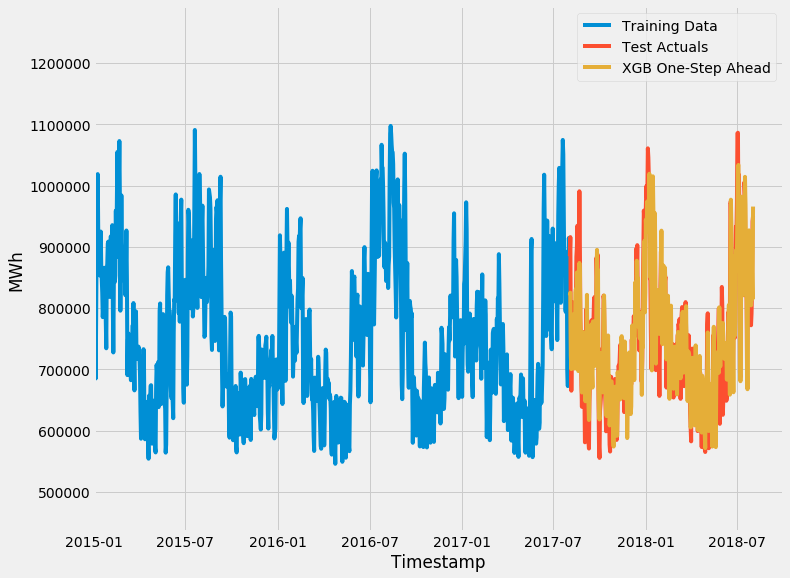

In [42]:
# Let's visually see the results
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Actuals')
plt.plot(XGB_prediction, label='XGB One-Step Ahead')

# Plot Labels, Legends etc
plt.xlabel("Timestamp")
plt.ylabel("MWh")
plt.legend(loc='best')

# For clarify, let's limit to only 2015 onwards
plt.xlim(datetime(2015, 1, 1),datetime(2018, 10, 1))


plt.show()

The results of the model are fairly accurate!

However, caveat is that because the model knows about yesterday's value. Therefore, the 'forecast horizon' (ie the maximum length of time it can predict into the future) is only 1 day. This is also known as a 'One-Step Ahead Forecast'.

If you only have yesterday's value, you can only predict today's value. If you only have today's value, you can only predict tomorrow's value.

Now let's see what the algorithm considered most important - we'll grab the **Top 10 features by weight**.

The weight is the percentage representing the relative number of times a particular feature occurs in the trees of the model. It's a rough way of saying the more times you reference a particular feature, the more likely it is important.

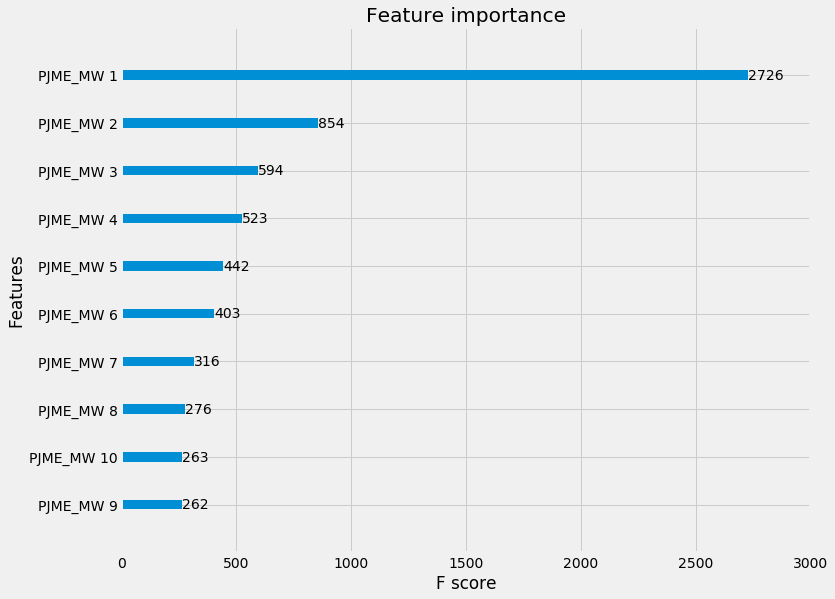

In [43]:
import xgboost as xgb

xgb.plot_importance(model, max_num_features=10, importance_type='weight') # "weight” is the number of times a feature appears in a tree

plt.show()

Seems like yesterday's value is the biggest factor in determining today's value! This, again, makes sense, given how the autocorrelation function showed yesterday's value had the biggest correlation with today's value.

## An alternative feature engineering approach - let's not include lag
Let's try to make the XGBoost model more than One-Step Ahead - we'll only feature engineer:

Day of the Week
Day of the Month
Day of the Year
Week of the Year
Month
Year
Hopefully this is enough for the model to artificially pick up 'seasonality' factors - e.g., if same day of week, might be correlated.

In [44]:
xtrain_no_lag = train.copy() #Otherwise it becomes a pointer
xtest_no_lag = test.copy() # Otherwise it becomes a pointer

train_feature, train_label = preprocess_xgb_data(xtrain_no_lag, include_lag=False)
test_feature, test_label = preprocess_xgb_data(xtest_no_lag, include_lag=False)

In [45]:
#Train and predict using XGBoost
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, train_test_split

# We will try with 1000 trees and a maximum depth of each tree to be 5
# Early stop if the model hasn't improved in 100 rounds
model = XGBRegressor(
    max_depth=6 # Default - 6
    ,n_estimators=1000
    ,booster='gbtree'
    ,colsample_bytree=1 # Subsample ratio of columns when constructing each tree - default 1
    ,eta=0.3 # Learning Rate - default 0.3
    ,importance_type='gain' # Default is gain
)
model.fit(
    train_feature
    ,train_label
    ,eval_set=[(train_feature, train_label)]
    ,eval_metric='mae'
    ,verbose=True
    ,early_stopping_rounds=100 # Stop after 100 rounds if it doesn't after 100 times
)

xtest['PJME_MW Prediction'] = model.predict(test_feature)
XGB_prediction_no_lag = xtest[['Datetime', 'PJME_MW Prediction']].set_index('Datetime')

[0]	validation_0-mae:540330.18750
Will train until validation_0-mae hasn't improved in 100 rounds.
[1]	validation_0-mae:378721.18750
[2]	validation_0-mae:265600.90625
[3]	validation_0-mae:186390.46875
[4]	validation_0-mae:131175.89062
[5]	validation_0-mae:93955.89844
[6]	validation_0-mae:70446.87500
[7]	validation_0-mae:55872.68750
[8]	validation_0-mae:48118.47266
[9]	validation_0-mae:44198.42188
[10]	validation_0-mae:42358.18359
[11]	validation_0-mae:40913.16016
[12]	validation_0-mae:40591.01172
[13]	validation_0-mae:40318.82422
[14]	validation_0-mae:39763.05469
[15]	validation_0-mae:38857.41016
[16]	validation_0-mae:38656.94922
[17]	validation_0-mae:38061.31250
[18]	validation_0-mae:37579.22656
[19]	validation_0-mae:37113.53516
[20]	validation_0-mae:36969.68359
[21]	validation_0-mae:36592.33594
[22]	validation_0-mae:35762.53125
[23]	validation_0-mae:35535.48828
[24]	validation_0-mae:34999.46484
[25]	validation_0-mae:34708.70703
[26]	validation_0-mae:34159.19531
[27]	validation_0-mae:

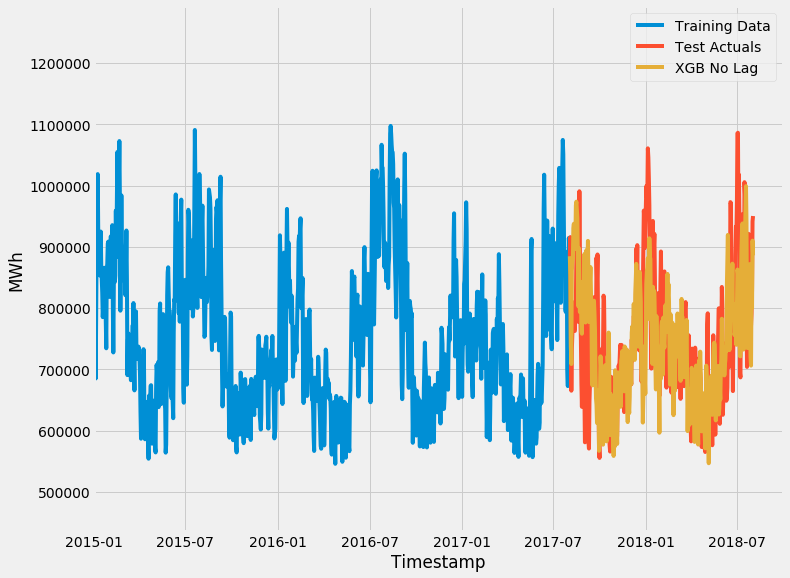

In [46]:
# Let's visually see the results
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Actuals')
plt.plot(XGB_prediction_no_lag, label='XGB No Lag')

# Plot Labels, Legends etc
plt.xlabel("Timestamp")
plt.ylabel("MWh")
plt.legend(loc='best')

# For clarify, let's limit to only 2015 onwards
plt.xlim(datetime(2015, 1, 1),datetime(2018, 10, 1))

plt.show()

Again let's see feature importance - this time by gain, not weight (as model trained on gain)

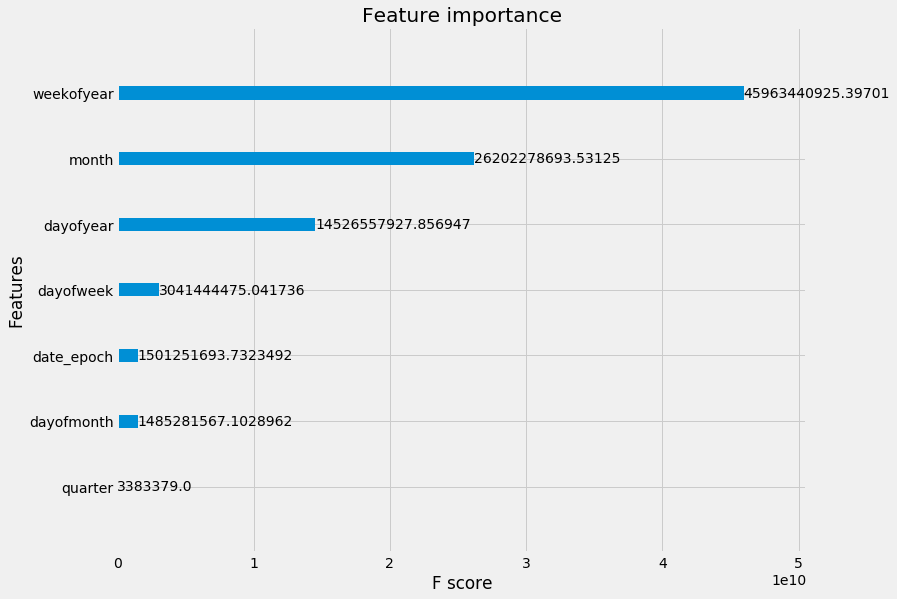

In [47]:
import xgboost as xgb

xgb.plot_importance(model, max_num_features=10, importance_type='gain') # gain is how much each feature contributed to 'improvement' of tree

plt.show()

Overall, quite good results!

# SARIMA

The conventional ARIMA model assumes that the historical data are useful to predict the value at the next time step. In this case, this is somewhat true, as the ACF plot before showed past value is somewhat correlated with today's value.

ARIMA basically integrates two naive forecasting techniques together:

1. **Autoregression** - Uses one or more past values to forecast the future. The number of values used is known as the 'order' (e.g. order 2 means yesterday and day before's value is used)

2. **Integrating** - the part that reduces seasonality. How many degrees of differencing is done to reduce seasonality is the 'order'.

3. **Moving Average** - Uses the Moving Average of the historical data to adjust the forecasted values. This has a 'smoothing' effect on the past data, as it uses the moving average rather than the actual values of the past. The number of days in the moving average window is the 'order'.

SARIMA then adds a '**seasonality**' flavour to the ARIMA model - it factors in trends and seasonality, as explained above.

The main hyperparameters are SARIMAX(p,d,q)(P,D,Q,m):
1. autoregression order (p)
2. Integrating order (d)
3. moving average window (q)
4. Seasonal autoregressive order (P)
5. Seasonal difference order (D)
6. Seasonal moving average order (Q)
7. number of time steps for a single seasonal period (m)

The X is the exogenous (external) variables to the model - they are optional and for this model we won't use them.

Like Holtwinters, the training and testing data was split between 2002 to 2017 and 2017 to 2018.

The results were as follows:


In [48]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import meanabs

# Equivalent to R's Auto ARIMA to get the optimal parameters
#import pmdarima as pm
#model = pm.auto_arima(htrain, seasonal=True, stationary=True, stepwise=True, trace=True, suppress_warnings=True)

# First we split it up between train and test
htrain = train['PJME_MW'] # SARIMAX takes series, not DF
htest = test['PJME_MW'] # SARIMAX takes series, not DF

# Next define hyperparameters. Default is AR model (1,0,0)(0,0,0,0)
p = 1 # AR order
d = 0 # I degree
q = 1 # MA window
P = 0 # AR seasonal order
D = 1 # I seasonal order
Q = 2 # MA seasonal order
m = 6 # Seasonality period length

model = SARIMAX(
    htrain,
    order=(p, d, q),
    seasonal_order=(P, D, Q, m)
    ,enforce_stationarity=False
    ,enforce_invertibility=False
).fit(
    maxiter=50 # Default is 50 
)

SARIMA_prediction = model.predict(start=htest.index[0], end=htest.index[-1])

# Evaluate it's performance using Mean Absolute Error (MAE)
print("Finished training and predicting. MAE SARIMA: {:.20f}. AIC: {}. Parameters: p,d,q,P,D,Q,m: ".format(meanabs(htest, SARIMA_prediction), model.aic), p,d,q,P,D,Q,m)

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Finished training and predicting. MAE SARIMA: 133423.53002751836902461946. AIC: 140977.25611411664. Parameters: p,d,q,P,D,Q,m:  1 0 1 0 1 2 6


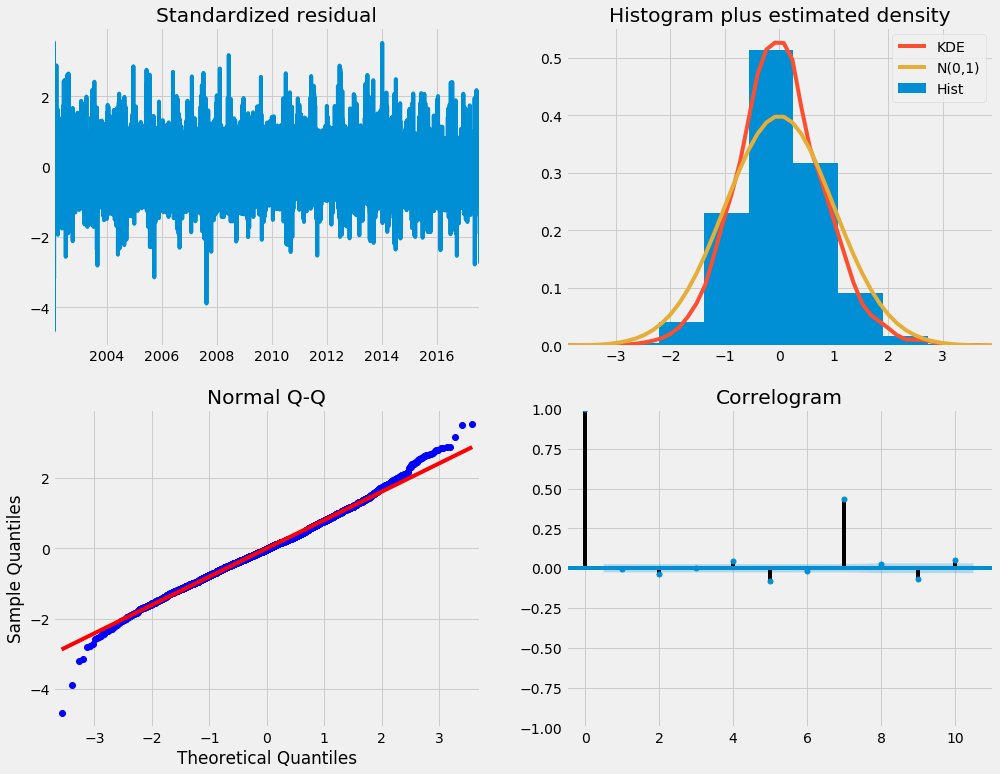

In [49]:
# Let's see what the model did
model.plot_diagnostics(figsize=(15, 12))
plt.show()

Importantly, the model should have the residuals uncorrelated and normally distributed (ie the mean should be zero). That is the, the centre point of the residuals should be zero and the distribution plot (KDE) should also be centred on 0.

Let's evaluate the results and visualise it.

In [50]:
# Evaluate it's performance using Mean Absolute Error (MAE)
from statsmodels.tools.eval_measures import meanabs

print("MAE SARIMA: {:.20f}".format(meanabs(htest, SARIMA_prediction)))

MAE SARIMA: 133423.53002751836902461946


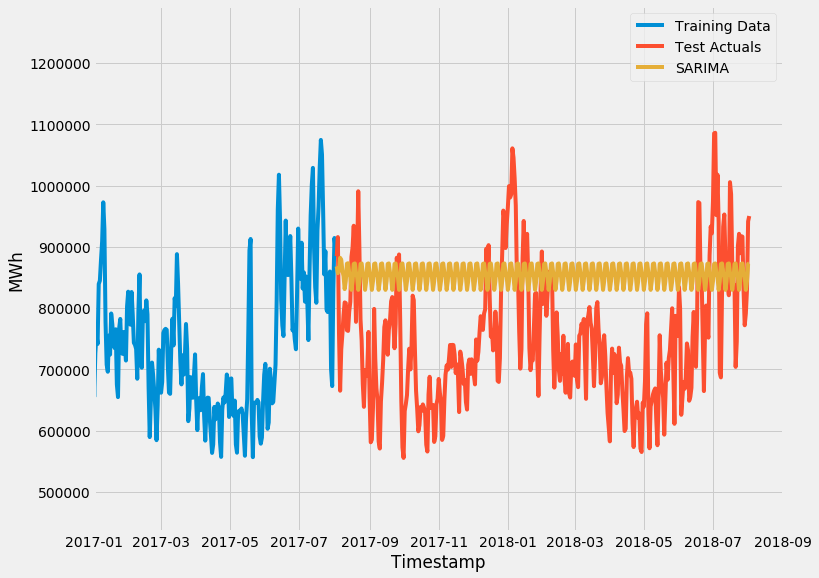

In [51]:
# Let's visually see the results
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Actuals')
plt.plot(SARIMA_prediction, label='SARIMA')

# Plot Labels, Legends etc
plt.xlabel("Timestamp")
plt.ylabel("MWh")
plt.legend(loc='best')

# For clarify, let's limit to only 2017 onwards
plt.xlim(datetime(2017, 1, 1),datetime(2018, 9, 1))

plt.show()

So you can see that despite some tuning, the results are not particularly good.

# Prophet

Lastly, we will use Facebook Prophet - an open-source library that is also a generalised additive model (ie final result is made up of multiple components added together).

## It's all about probabilities!

Unlike regular Generalised Linear Models, Facebook Prophet's uses a Bayesian curve fitting approach. The concept of Bayesian theorem is, at high level, trying to determine the probability of related events given knowledge/assumptions you already know (ie 'priors').

This is basically fancy talk for saying it focuses on finding a bunch of possible parameters and the probability of each one rather than finding fixed optimal values for the model. How certain (or uncertain) the model is about each possible parameter is known as the 'uncertainty interval' - the less data the model sees, the bigger the interval is.

The sources of uncertainty that Prophet's Bayesian approach aims to address are:

* Uncertainty of the predicted value
* Uncertainty of the trend and trend changes
* Uncertainty of additional noise

## Trends, 'Changepoints' and Seasonality

Prophet is different to SARIMA and HoltWinters, as it essentially decomposes time series differently by:

**Data = Trend +/x Seasonality +/x Holidays +/x Noise**

In Prophet, trend represents non-periodic changes while seasonality represents periodic changes. Where it differs from other statistic models like SARIMA and Holtwinters is Prophet factors in the uncertainty of trends changing.

Interestingly, Prophet fits a curve to each component independently (ie fits a regression for each component with time as independent variable). That is:

Trend - fits piece-wise linear/log curve
Seasonality - uses fourier series
Holidays - uses constant/fixed values
Prophet reacts to changes in trends by 'changepoints' - that is sudden and abrupt changes in the trend. An example, is the release of a new electric car that will impact sale of petrol cars.

How 'reactive'/flexible Prophet is to changepoints will impact how much fluctation the model will do. For example, when the changepoint scale is to very high, it becomes very sensitive and any small changes to the trend will be picked up. Consequently, the sensitive model may detect spikes that won't amount to anything, while an insensitive model may miss spikes altogether.

The uncertainty of the predictions is determined by the number of changepoints and the flexibility of the changepoint allowed. In other words, if there were many changes in the past, there's likely going to be many changes in the future. Prophet gets the uncertainty by randomly sampling changepoints and seeing what happened before and after.

Furthermore, Prophet factors in seasonality by considering both its length (ie seasonal period) and its frequency (ie its 'fourier order').For example, if something keeps happening every week on Monday, the period is 7 days and its frequency is 52 times a year.

There's also a function for Prophet to consider additional factors (e.g. holidays), but for the purposes of this forecast we won't use it.


## Training
Prophet works quite well out of the box, so I just stuck with the default hyperparameters.

The results can be seen below, with the black dots representing historical points and the blue line representing the prediction:

In [52]:
from fbprophet import Prophet

ftrain = train.reset_index().rename(columns={'Datetime':'ds', 'PJME_MW': 'y'}) # Prophet takes ds and y as column names only

model = Prophet(
    n_changepoints=25 # Default is 25
    ,changepoint_prior_scale=0.05 # Default is 0.05
    ,seasonality_mode='additive'
)
model.fit(ftrain)

# Create the future dataframe with date range that will be used to test accuracy
future_df = test.reset_index()['Datetime'].to_frame().rename(columns={"Datetime":'ds'})

# Predict the future
forecast = model.predict(future_df)

PROPHET_prediction = forecast.set_index('ds')['yhat'][cutoff:]

print("Finished training and predicting")

Finished training and predicting


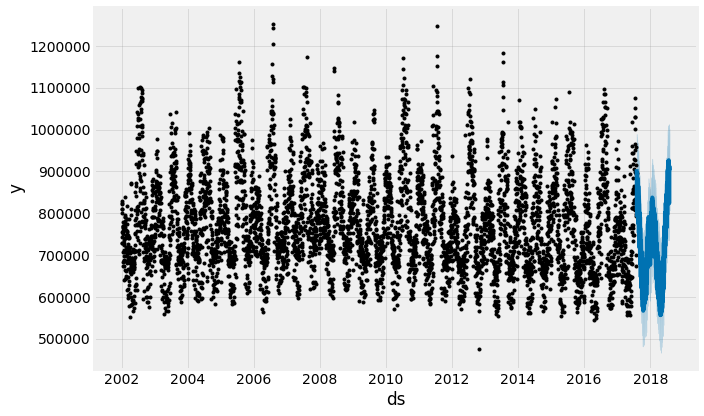

In [53]:
model.plot(forecast)

plt.show()

Like Holtwinters, let's see the components of the model:

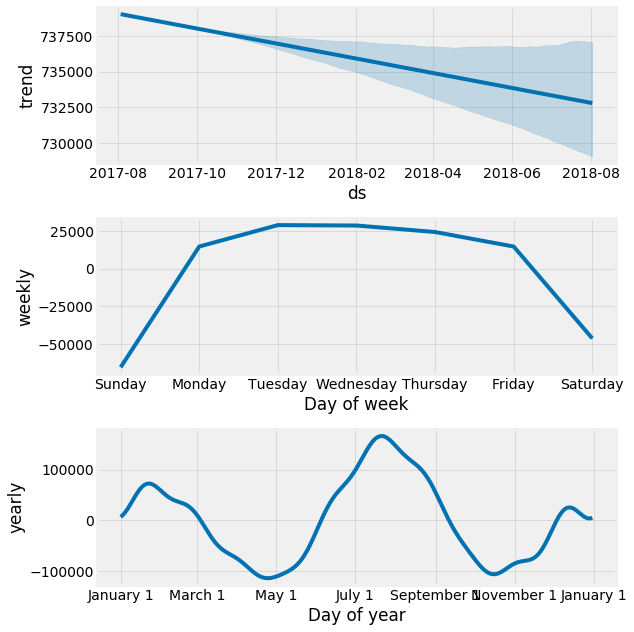

In [54]:
model.plot_components(forecast)

plt.show()

You can easily see seasonality and trends - there's a clear downward trend and seasonality every year (more electricity is used in winter)

# Bringing it all together - the final results

Finally, Let's bring the models together and see which one did the best:

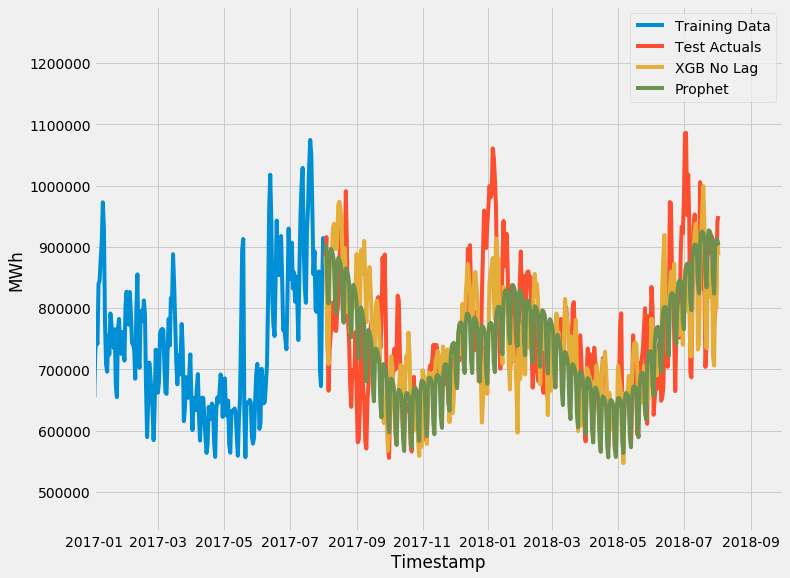

In [55]:
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Actuals')
#plt.plot(HWES_prediction, label='HWES')
plt.plot(XGB_prediction_no_lag, label='XGB No Lag')
#plt.plot(SARIMA_prediction, label='SARIMA')
plt.plot(PROPHET_prediction, label='Prophet')
# Plot Labels, Legends etc
plt.xlabel("Timestamp")
plt.ylabel("MWh")
plt.legend(loc='best')

# For clarify, let's limit to only 2017 onwards
plt.xlim(datetime(2017, 1, 1),datetime(2018, 10, 1))

plt.show()

The final MAE results between the models

In [56]:
print("MAE Baseline: {:.20f}".format(meanabs(test['PJME_MW'], baseline_prediction['PJME_MW'])))
print("MAE HWES ADD: {:.20f}".format(meanabs(test['PJME_MW'], HWES_prediction)))
print("MAE XGB: {:.20f}".format(mean_absolute_error(test_label, XGB_prediction['PJME_MW Prediction'])))
print("MAE XGB No Lag: {:.20f}".format(mean_absolute_error(test_label, XGB_prediction_no_lag['PJME_MW Prediction'])))
print("MAE SARIMA: {:.20f}".format(meanabs(test['PJME_MW'], SARIMA_prediction)))
print("MAE Prophet: {:.20f}".format(meanabs(test['PJME_MW'], PROPHET_prediction)))

MAE Baseline: 87418.90958904109720606357
MAE HWES ADD: 158807.87162270283442921937
MAE XGB: 43437.22089041095750872046
MAE XGB No Lag: 68307.28561643835564609617
MAE SARIMA: 133423.53002751836902461946
MAE Prophet: 61524.73085262985841836780


The lower the error the better/more accurate the model is, so therefore in this case, XGBoost One-Step Ahead was the most accurate. However, this is because the forecast horizon is only one day and you would expect it to be pretty accurate. Therefore, it wouldn't be fair to compare one-step ahead with the other forecasting models.

In light of this, the winner is Prophet! However, XGBoost still comes a pretty close second!

You can see that there was a lot of noise in this dataset and while there's high seasonality, more conventional statistical approaches, such as Holtwinters and SARIMA weren't able to get through all that noise.

Interestingly, all the forecasting models beat the baseline, except SARIMA. This does at least demonstrate that we are still better off using these models than just doing naive forecasting.

Hopefully that gives you a bit of a flavour to time series forecasting and some of the unique aspects of it!